## Final Project Submission

Please fill out:
* Student name: Moses Lin
* Student pace: full time
* Scheduled project review date/time: 7/31/2020
* Instructor name: Sean Abu Wilson
* Blog post URL:

# Source:

Data was downloaded from Kaggle, and contains a dataset of Steam Games gathered from the Steam Store and SteamSpy API around May 2019.

https://www.kaggle.com/nikdavis/steam-store-games

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('seaborn')
sns.set(style="white")
import itertools
import re
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from math import exp

In [2]:
df = pd.read_csv('steam.csv')
df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


# Cleaning Data

As usual, first thing to do is to check for null values. It is ideal to fill in values for observations if possible instead of outright removing them, as we would be losing a lot of data.

In [3]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

df.isna().sum()
#Checking how many missing numbers there are
#Makes sense, since this dataset said it was "clean"

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

In [4]:
#about 1.9% of all games in this set are not in English, will drop non-english games.
print(511/(26564+511))
df['english'].value_counts()

0.01887349953831948


1    26564
0      511
Name: english, dtype: int64

In [5]:
df['required_age'].value_counts()
#seems most games do not have a rating listed, will drop this column

0     26479
18      308
16      192
12       73
7        12
3        11
Name: required_age, dtype: int64

In [6]:
#Dropping columns that don't seem particularly useful.
df.drop(columns=['appid', 'steamspy_tags', 'english', 'required_age', 'owners'], inplace=True)
df.head()

,name,release_date,developer,publisher,platforms,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
0,Counter-Strike,2000-11-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,124534,3339,17612,317,7.19
1,Team Fortress Classic,1999-04-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,3318,633,277,62,3.99
2,Day of Defeat,2003-05-01,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,0,3416,398,187,34,3.99
3,Deathmatch Classic,2001-06-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,1273,267,258,184,3.99
4,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,0,5250,288,624,415,3.99


In [7]:
df['release_date'] = df['release_date'].astype('datetime64[ns]')
df['release_year'] = df['release_date'].apply(lambda x: x.year)

In [22]:
df['price'].sort_values(ascending=False).head(30)
df['price'] = df.price[df['price'] < 70.00]

# Target Variable

Because number of positive reviews out of negative reviews is a little vague, and not really representative of scoring if there are very few reviews. I will be using the formula from https://steamdb.info/blog/steamdb-rating/.

totalreview = positiverating + negativerating

reviewscore = positiverating / totalreview

rating = reviewscore - (reviewscore - 0.5) * (2**(-log10(totalreview + 1)))

In [9]:
import numpy as np
df['totalreview'] = df['positive_ratings'] + df['negative_ratings']
df['reviewscore'] = df['positive_ratings'] / df['totalreview']
df['rating'] = df['reviewscore'] - (df['reviewscore'] - 0.5) * (2 ** (-np.log10(df['totalreview'] + 1)))
df.head()

,name,release_date,developer,publisher,platforms,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,totalreview,reviewscore,rating
0,Counter-Strike,2000-11-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,124534,3339,17612,317,7.19,2000,127873,0.973888,0.960136
1,Team Fortress Classic,1999-04-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,3318,633,277,62,3.99,1999,3951,0.839787,0.811703
2,Day of Defeat,2003-05-01,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,0,3416,398,187,34,3.99,2003,3814,0.895648,0.862598
3,Deathmatch Classic,2001-06-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,1273,267,258,184,3.99,2001,1540,0.826623,0.790779
4,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,0,5250,288,624,415,3.99,1999,5538,0.947996,0.914546


In [10]:
top10 = df.nlargest(10, ['rating'])
worst10 = df.nsmallest(10, ['rating'])

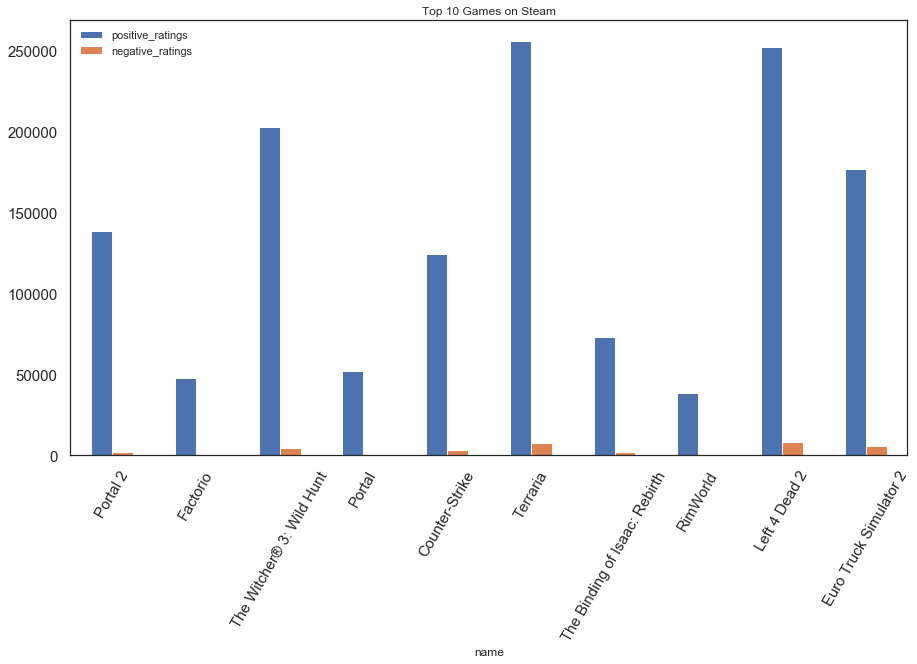

In [11]:
top10.plot(x='name', y=['positive_ratings', 'negative_ratings'], kind='bar', figsize=(15,8),title='Top 10 Games on Steam', fontsize=15, rot=60)

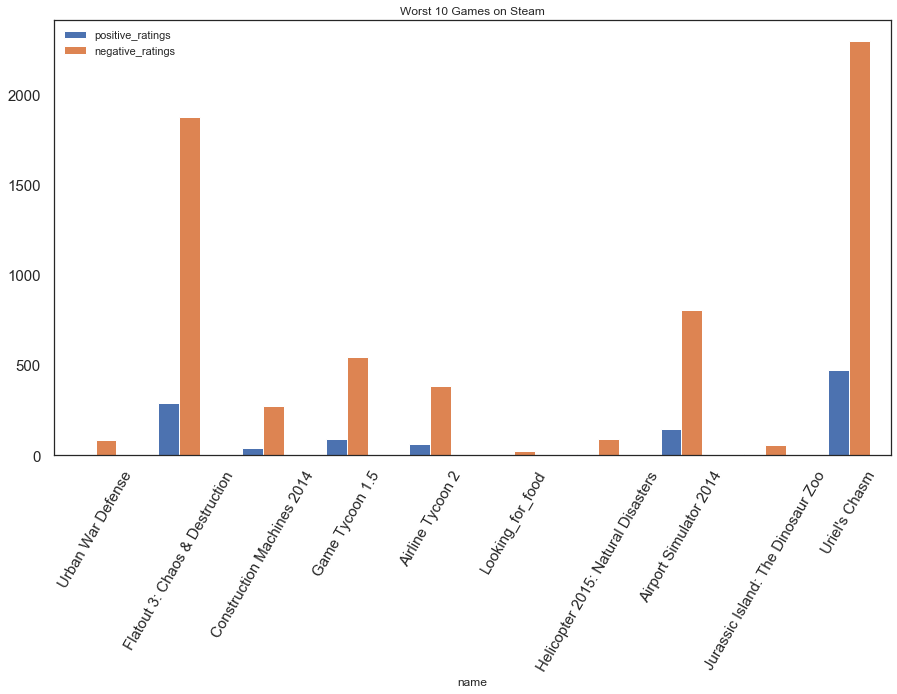

In [12]:
worst10.plot(x='name', y=['positive_ratings', 'negative_ratings'], kind='bar', figsize=(15,8),title='Worst 10 Games on Steam', fontsize=15, rot=60)

# Exploratory Data Analysis

In [13]:
df2005up = df[df['release_year'].between(2005, 2018)]
df2005up

,name,release_date,developer,publisher,platforms,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,totalreview,reviewscore,rating
12,Day of Defeat: Source,2010-07-12,Valve,Valve,windows;mac;linux,Multi-player;Cross-Platform Multiplayer;Steam ...,Action,54,10489,1210,1356,134,7.19,2010,11699,0.896572,0.872931
14,Half-Life 2: Lost Coast,2005-10-27,Valve,Valve,windows;mac;linux,Single-player;Commentary available,Action,0,5783,1020,46,29,0.00,2005,6803,0.850066,0.825498
15,Half-Life Deathmatch: Source,2006-05-01,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,0,1362,473,102,81,0.00,2006,1835,0.742234,0.717016
16,Half-Life 2: Episode One,2006-06-01,Valve,Valve,windows;mac;linux,Single-player;Steam Achievements;Captions avai...,Action,13,7908,517,281,184,5.79,2006,8425,0.938635,0.909770
17,Portal,2007-10-10,Valve,Valve,windows;mac;linux,Single-player;Steam Achievements;Captions avai...,Action,15,51801,1080,288,137,7.19,2007,52881,0.979577,0.961422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26046,BLASTER LiLO,2018-12-28,Fabio Cardini,Fabio Cardini,windows,Single-player;Online Multi-Player;Steam Achiev...,Action,14,1,0,0,0,1.99,2018,1,1.000000,0.594164
26047,Mobile Wars X,2018-12-28,NAPE GAMES,NAPE GAMES,windows,Single-player,Action;Casual;Free to Play;Indie,0,16,6,0,0,0.00,2018,22,0.727273,0.638837
26074,Tower Behind the Moon,2018-12-20,Choice of Games,Choice of Games,windows;mac;linux,Single-player;Steam Achievements;Steam Cloud,Adventure;Indie;RPG,35,6,4,0,0,5.19,2018,10,0.600000,0.551414
26082,aMAZE Valentine,2018-12-28,Blender Games,Blender Games,windows,Single-player;Steam Achievements,Casual;Indie,100,13,2,0,0,0.79,2018,15,0.866667,0.707521


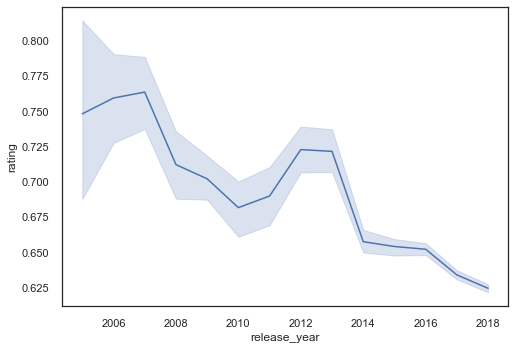

In [37]:
ax = sns.lineplot(x="release_year", y="rating", data=df2005up)

In [16]:
print(df['achievements'].value_counts())

print(df.achievements[df.achievements == 0].count())
print(df.achievements[df.achievements > 0].count())
# Will separate into dummy column of whether there are achievements or not

0       11864
10        679
12        618
20        574
15        490
        ...  
184         1
168         1
1487        1
319         1
4094        1
Name: achievements, Length: 410, dtype: int64
11864
15211


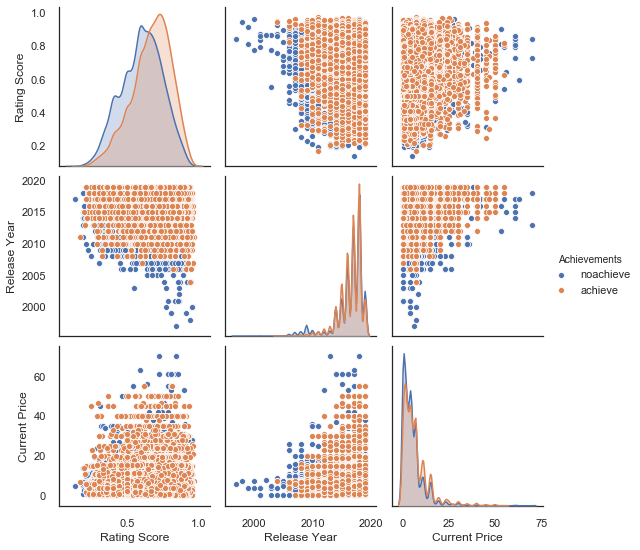

In [17]:
df['containachieve'] = 'noachieve'
df.loc[df['achievements'] > 0, 'containachieve'] = 'achieve'

achievedf = pd.DataFrame(zip(df['rating'],
                          df['release_year'],
                          df['price'],
                          df['containachieve']
                         ),
                      columns=['Rating Score', 'Release Year', 'Current Price', 'Achievements'])

sns.pairplot(achievedf, hue='Achievements')
plt.show()

In [18]:
print(df['price'].value_counts())

print(df.price[df.price == 0.00].count())
print(df.price[df.price > 0.00].count())

3.99     3211
0.79     2892
0.00     2560
6.99     2050
7.19     1304
         ... 
15.40       1
7.74        1
19.90       1
6.35        1
6.28        1
Name: price, Length: 271, dtype: int64
2560
24495


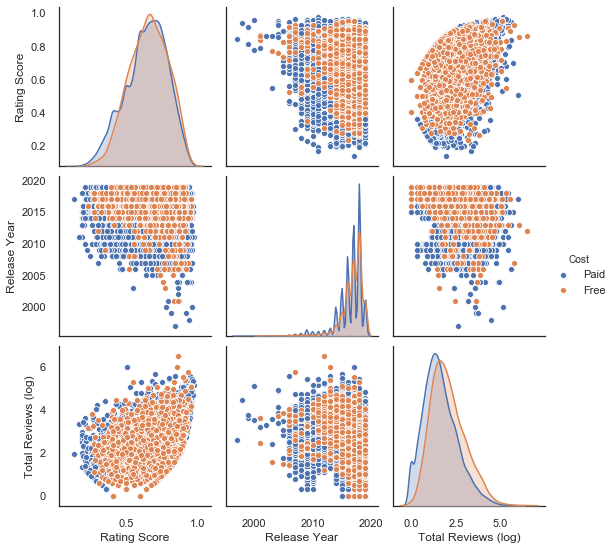

In [19]:
df['Cost'] = 'Free'
df.loc[df['price'] > 0, 'Cost'] = 'Paid'

achievedf = pd.DataFrame(zip(df['rating'],
                          df['release_year'],
                          np.log10(df['totalreview']),
                          df['Cost']
                         ),
                      columns=['Rating Score', 'Release Year', 'Total Reviews (log)', 'Cost'])

sns.pairplot(achievedf, hue='Cost')
plt.show()

# Making Dummy Variables for Later

In [25]:
def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

#Get unique values from a Pandas series containing semi-colon delimited strings.

In [26]:
platformcols = get_unique(df['platforms'])
platformcols

for col in platformcols:
    df[col] = df['platforms'].apply(lambda x: 1 if col in x.split(';') else 0)

df = df.drop(columns='platforms')
df

,name,release_date,developer,publisher,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,totalreview,reviewscore,rating,containachieve,Cost,linux,mac,windows
0,Counter-Strike,2000-11-01,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,124534,3339,17612,317,7.19,2000,127873,0.973888,0.960136,noachieve,Paid,1,1,1
1,Team Fortress Classic,1999-04-01,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,3318,633,277,62,3.99,1999,3951,0.839787,0.811703,noachieve,Paid,1,1,1
2,Day of Defeat,2003-05-01,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,0,3416,398,187,34,3.99,2003,3814,0.895648,0.862598,noachieve,Paid,1,1,1
3,Deathmatch Classic,2001-06-01,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,1273,267,258,184,3.99,2001,1540,0.826623,0.790779,noachieve,Paid,1,1,1
4,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,Single-player;Multi-player;Valve Anti-Cheat en...,Action,0,5250,288,624,415,3.99,1999,5538,0.947996,0.914546,noachieve,Paid,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,Single-player;Steam Achievements,Adventure;Casual;Indie,7,3,0,0,0,2.09,2019,3,1.000000,0.670594,achieve,Paid,0,0,1
27071,Cyber Gun,2019-04-23,Semyon Maximov,BekkerDev Studio,Single-player,Action;Adventure;Indie,0,8,1,0,0,1.69,2019,9,0.888889,0.694444,noachieve,Paid,0,0,1
27072,Super Star Blast,2019-04-24,EntwicklerX,EntwicklerX,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,24,0,1,0,0,3.99,2019,1,0.000000,0.405836,achieve,Paid,0,0,1
27073,New Yankee 7: Deer Hunters,2019-04-17,Yustas Game Studio,Alawar Entertainment,Single-player;Steam Cloud,Adventure;Casual;Indie,0,2,0,0,0,5.19,2019,2,1.000000,0.640795,noachieve,Paid,0,1,1


In [88]:
platcolval = df[list(platformcols)]
platcolval

,linux,mac,windows
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
27070,0,0,1
27071,0,0,1
27072,0,0,1
27073,0,1,1


In [27]:
genrecols = get_unique(df['genres'])
genrecols

for col in genrecols:
    df[col] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)

df = df.drop(columns='genres')
df

,name,release_date,developer,publisher,categories,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,totalreview,reviewscore,rating,containachieve,Cost,linux,mac,windows,Tutorial,Action,Web Publishing,Software Training,Accounting,Casual,Sports,RPG,Game Development,Early Access,Utilities,Sexual Content,Indie,Video Production,Photo Editing,Education,Gore,Documentary,Massively Multiplayer,Simulation,Design & Illustration,Free to Play,Violent,Nudity,Strategy,Animation & Modeling,Adventure,Racing,Audio Production
0,Counter-Strike,2000-11-01,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,0,124534,3339,17612,317,7.19,2000,127873,0.973888,0.960136,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Team Fortress Classic,1999-04-01,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,0,3318,633,277,62,3.99,1999,3951,0.839787,0.811703,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Day of Defeat,2003-05-01,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,0,3416,398,187,34,3.99,2003,3814,0.895648,0.862598,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Deathmatch Classic,2001-06-01,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,0,1273,267,258,184,3.99,2001,1540,0.826623,0.790779,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,Single-player;Multi-player;Valve Anti-Cheat en...,0,5250,288,624,415,3.99,1999,5538,0.947996,0.914546,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,Single-player;Steam Achievements,7,3,0,0,0,2.09,2019,3,1.000000,0.670594,achieve,Paid,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
27071,Cyber Gun,2019-04-23,Semyon Maximov,BekkerDev Studio,Single-player,0,8,1,0,0,1.69,2019,9,0.888889,0.694444,noachieve,Paid,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
27072,Super Star Blast,2019-04-24,EntwicklerX,EntwicklerX,Single-player;Multi-player;Co-op;Shared/Split ...,24,0,1,0,0,3.99,2019,1,0.000000,0.405836,achieve,Paid,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27073,New Yankee 7: Deer Hunters,2019-04-17,Yustas Game Studio,Alawar Entertainment,Single-player;Steam Cloud,0,2,0,0,0,5.19,2019,2,1.000000,0.640795,noachieve,Paid,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [33]:
gencolval = df[list(genrecols)]
gencolval

,Tutorial,Action,Web Publishing,Software Training,Accounting,Casual,Sports,RPG,Game Development,Early Access,Utilities,Sexual Content,Indie,Video Production,Photo Editing,Education,Gore,Documentary,Massively Multiplayer,Simulation,Design & Illustration,Free to Play,Violent,Nudity,Strategy,Animation & Modeling,Adventure,Racing,Audio Production
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
27071,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
27072,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27073,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
categorycols = get_unique(df['categories'])
categorycols

for col in categorycols:
    df[col] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)

df = df.drop(columns='categories')
df

,name,release_date,developer,publisher,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,totalreview,reviewscore,rating,containachieve,Cost,linux,mac,windows,Tutorial,Action,Web Publishing,Software Training,Accounting,Casual,Sports,RPG,Game Development,Early Access,Utilities,Sexual Content,Indie,Video Production,Photo Editing,Education,Gore,Documentary,Massively Multiplayer,Simulation,Design & Illustration,Free to Play,Violent,Nudity,Strategy,Animation & Modeling,Adventure,Racing,Audio Production,VR Support,Steam Leaderboards,Stats,Includes Source SDK,Multi-player,Steam Achievements,SteamVR Collectibles,Shared/Split Screen,Single-player,Steam Turn Notifications,MMO,Co-op,Local Multi-Player,Partial Controller Support,Local Co-op,Online Co-op,Full controller support,Mods,In-App Purchases,Captions available,Valve Anti-Cheat enabled,Mods (require HL2),Steam Cloud,Steam Workshop,Cross-Platform Multiplayer,Online Multi-Player,Commentary available,Steam Trading Cards,Includes level editor
0,Counter-Strike,2000-11-01,Valve,Valve,0,124534,3339,17612,317,7.19,2000,127873,0.973888,0.960136,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,Team Fortress Classic,1999-04-01,Valve,Valve,0,3318,633,277,62,3.99,1999,3951,0.839787,0.811703,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,Day of Defeat,2003-05-01,Valve,Valve,0,3416,398,187,34,3.99,2003,3814,0.895648,0.862598,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Deathmatch Classic,2001-06-01,Valve,Valve,0,1273,267,258,184,3.99,2001,1540,0.826623,0.790779,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,5250,288,624,415,3.99,1999,5538,0.947996,0.914546,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,7,3,0,0,0,2.09,2019,3,1.000000,0.670594,achieve,Paid,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27071,Cyber Gun,2019-04-23,Semyon Maximov,BekkerDev Studio,0,8,1,0,0,1.69,2019,9,0.888889,0.694444,noachieve,Paid,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27072,Super Star Blast,2019-04-24,EntwicklerX,EntwicklerX,24,0,1,0,0,3.99,2019,1,0.000000,0.405836,achieve,Paid,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
27073,New Yankee 7: Deer Hunters,2019-04-17,Yustas Game Studio,Alawar Entertainment,0,2,0,0,0,5.19,2019,2,1.000000,0.640795,noachieve,Paid,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [36]:
catcolval = df[list(categorycols)]
catcolval

,VR Support,Steam Leaderboards,Stats,Includes Source SDK,Multi-player,Steam Achievements,SteamVR Collectibles,Shared/Split Screen,Single-player,Steam Turn Notifications,MMO,Co-op,Local Multi-Player,Partial Controller Support,Local Co-op,Online Co-op,Full controller support,Mods,In-App Purchases,Captions available,Valve Anti-Cheat enabled,Mods (require HL2),Steam Cloud,Steam Workshop,Cross-Platform Multiplayer,Online Multi-Player,Commentary available,Steam Trading Cards,Includes level editor
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27072,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
27073,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# More Data Analysis

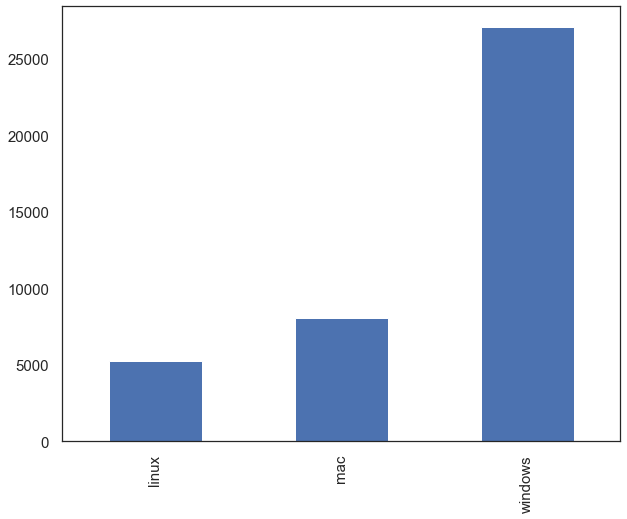

In [62]:
ax = platcolval.sum().plot.bar(figsize=(10,8), fontsize = 15)

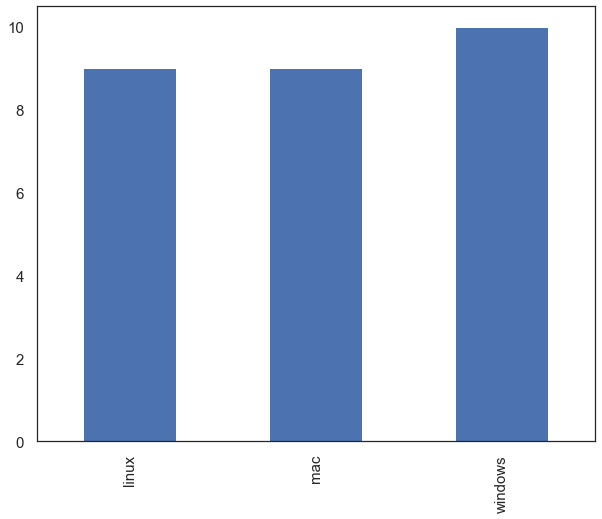

In [63]:
ax = df.sort_values(by='rating', ascending=False)[list(platformcols)].head(10).sum().plot.bar(figsize=(10,8), fontsize = 15)

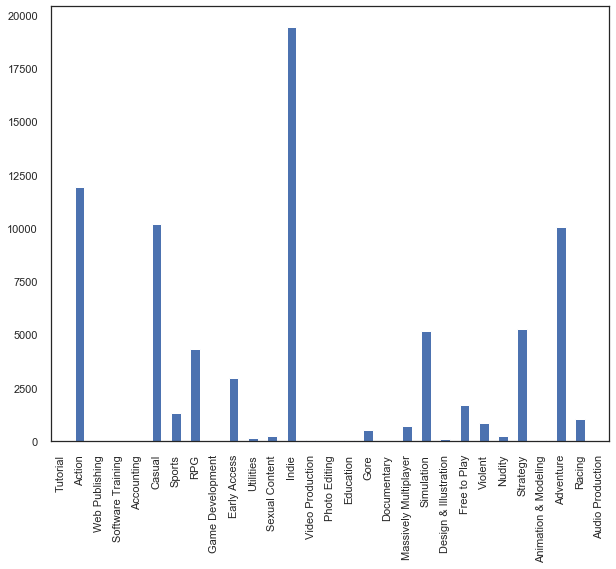

In [64]:
ax = gencolval.sum().plot.bar(figsize=(10,8))

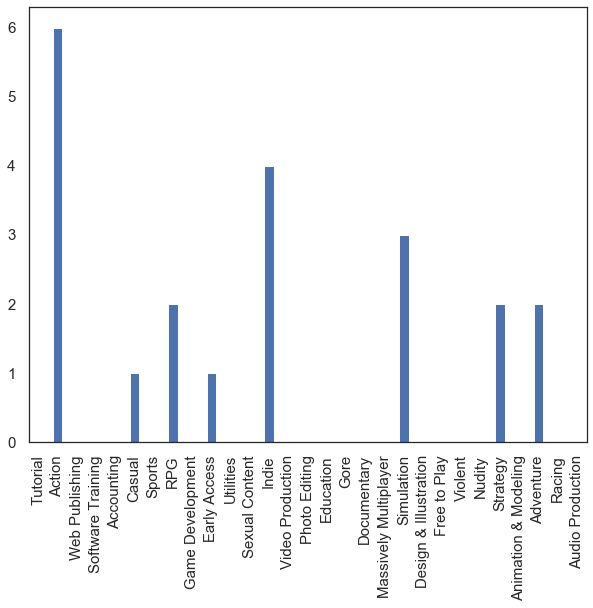

In [65]:
ax = df.sort_values(by='rating', ascending=False)[list(genrecols)].head(10).sum().plot.bar(figsize=(10,8), fontsize = 15)

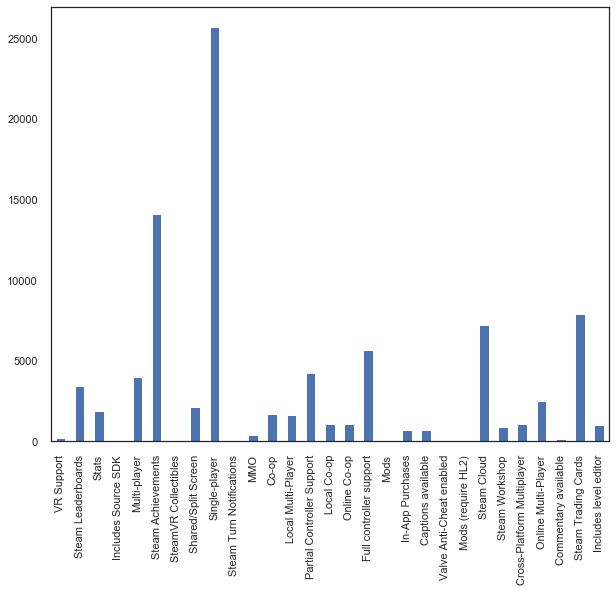

In [66]:
ax = catcolval.sum().plot.bar(figsize=(10,8))

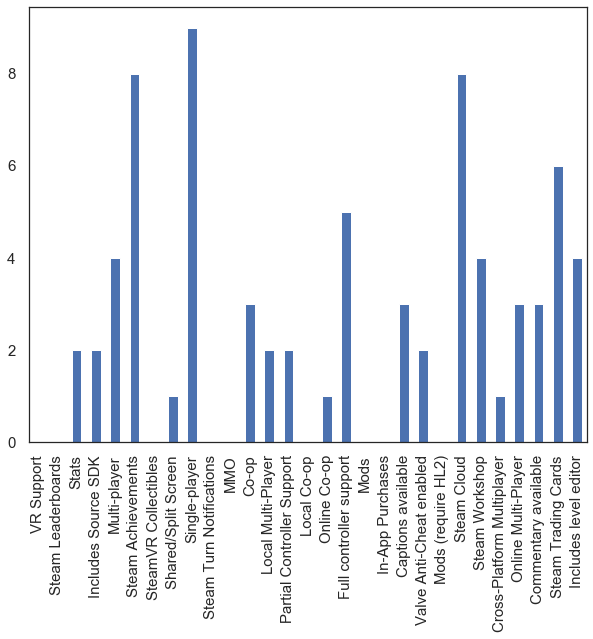

In [67]:
ax = df.sort_values(by='rating', ascending=False)[list(categorycols)].head(10).sum().plot.bar(figsize=(10,8), fontsize = 15)

# Hypothesis Testing

## Test 1:

Null Hypothesis: There is no statisically significant difference in average rating across platforms.

Alternative Hypothesis: There is a statisically significant difference in average rating across platforms.

In [97]:
#print(platcolval['linux'].value_counts())
#print(platcolval['mac'].value_counts())
#print(platcolval['windows'].value_counts())

linux = df.sort_values(by='linux', ascending=False).head(5235)
print(linux['rating'].mean())
mac = df.sort_values(by='mac', ascending=False).head(8066)
print(mac['rating'].mean())
windows = df.sort_values(by='windows', ascending=False).head(27070)
print(windows['rating'].mean())

0.6952754722263711
0.6844579028705016
0.6433503282605261


In [96]:
stats.f_oneway(linux['rating'], mac['rating'], windows['rating'])

F_onewayResult(statistic=466.51266101738497, pvalue=5.035619982069032e-201)

## Test 2:

Null Hypothesis: There is no statisically significant difference in average rating across Top 10 genres.

Alternative Hypothesis: There is a statisically significant difference in average rating across Top 10 genres.

In [102]:
#print(gencolval['Action'].value_counts())
#print(gencolval['Casual'].value_counts())
#print(gencolval['RPG'].value_counts())
#print(gencolval['Early Access'].value_counts())
#print(gencolval['Indie'].value_counts())
#print(gencolval['Simulation'].value_counts())
#print(gencolval['Strategy'].value_counts())
#print(gencolval['Adventure'].value_counts())

action = df.sort_values(by='Action', ascending=False).head(11903)
print(action['rating'].mean())
casual = df.sort_values(by='Casual', ascending=False).head(10210)
print(casual['rating'].mean())
rpg = df.sort_values(by='RPG', ascending=False).head(4311)
print(rpg['rating'].mean())
earlyacc = df.sort_values(by='Early Access', ascending=False).head(2954)
print(earlyacc['rating'].mean())
indie = df.sort_values(by='Indie', ascending=False).head(7654)
print(indie['rating'].mean())
simulation = df.sort_values(by='Simulation', ascending=False).head(5194)
print(simulation['rating'].mean())
strategy = df.sort_values(by='Strategy', ascending=False).head(5247)
print(strategy['rating'].mean())
adventure = df.sort_values(by='Adventure', ascending=False).head(10032)
print(adventure['rating'].mean())

0.6413595843095746
0.629594291756776
0.6556495792793557
0.6240390648745799
0.6346286555567465
0.6148819361200676
0.6340244396607405
0.6459509381305035


In [103]:
stats.f_oneway(action['rating'], casual['rating'], rpg['rating'], earlyacc['rating'], indie['rating'], simulation['rating'], strategy['rating'], adventure['rating'])

F_onewayResult(statistic=43.89373482527991, pvalue=2.5338004440679598e-62)

## Test 3:

Null Hypothesis: There is no statisically significant difference in average rating across Top 10 categories.

Alternative Hypothesis: There is a statisically significant difference in average rating between across Top 10 categories.

In [107]:
#print(catcolval['Stats'].value_counts())
#print(catcolval['Includes Source SDK'].value_counts())
#print(catcolval['Multi-player'].value_counts())
#print(catcolval['Steam Achievements'].value_counts())
#print(catcolval['Shared/Split Screen'].value_counts())
#print(catcolval['Single-player'].value_counts())
#print(catcolval['Co-op'].value_counts())
#print(catcolval['Local Multi-Player'].value_counts())
#print(catcolval['Partial Controller Support'].value_counts())
#print(catcolval['Online Co-op'].value_counts())
#print(catcolval['Full controller support'].value_counts())
#print(catcolval['Captions available'].value_counts())
#print(catcolval['Valve Anti-Cheat enabled'].value_counts())
#print(catcolval['Steam Cloud'].value_counts())
#print(catcolval['Steam Workshop'].value_counts())
#print(catcolval['Cross-Platform Multiplayer'].value_counts())
#print(catcolval['Online Multi-Player'].value_counts())
#print(catcolval['Commentary available'].value_counts())
#print(catcolval['Steam Trading Cards'].value_counts())
#print(catcolval['Includes level editor'].value_counts())

sstats = df.sort_values(by='Stats', ascending=False).head(1878)
print(sstats['rating'].mean())
sdk = df.sort_values(by='Includes Source SDK', ascending=False).head(35)
print(sdk['rating'].mean())
mp = df.sort_values(by='Multi-player', ascending=False).head(3974)
print(mp['rating'].mean())
steamach = df.sort_values(by='Steam Achievements', ascending=False).head(14130)
print(steamach['rating'].mean())
shared = df.sort_values(by='Shared/Split Screen', ascending=False).head(2152)
print(shared['rating'].mean())
sp = df.sort_values(by='Single-player', ascending=False).head(1397)
print(sp['rating'].mean())
coop = df.sort_values(by='Co-op', ascending=False).head(1721)
print(coop['rating'].mean())
localmp = df.sort_values(by='Local Multi-Player', ascending=False).head(1615)
print(localmp['rating'].mean())
pcs = df.sort_values(by='Partial Controller Support', ascending=False).head(4234)
print(pcs['rating'].mean())
oncoop = df.sort_values(by='Online Co-op', ascending=False).head(1071)
print(oncoop['rating'].mean())
fcs = df.sort_values(by='Full controller support', ascending=False).head(5695)
print(fcs['rating'].mean())
caption = df.sort_values(by='Captions available', ascending=False).head(721)
print(caption['rating'].mean())
nocheat = df.sort_values(by='Valve Anti-Cheat enabled', ascending=False).head(94)
print(nocheat['rating'].mean())
cloud = df.sort_values(by='Steam Cloud', ascending=False).head(7219)
print(cloud['rating'].mean())
workshop = df.sort_values(by='Steam Workshop', ascending=False).head(897)
print(workshop['rating'].mean())
crossplat = df.sort_values(by='Cross-Platform Multiplayer', ascending=False).head(1081)
print(crossplat['rating'].mean())
onmp = df.sort_values(by='Online Multi-Player', ascending=False).head(2487)
print(onmp['rating'].mean())
comment = df.sort_values(by='Commentary available', ascending=False).head(144)
print(comment['rating'].mean())
tradecard = df.sort_values(by='Steam Trading Cards', ascending=False).head(7198)
print(tradecard['rating'].mean())
leveledit = df.sort_values(by='Includes level editor', ascending=False).head(1036)
print(leveledit['rating'].mean())

0.6756181728231616
0.7474592452882481
0.6529350906747
0.674196390159534
0.6764254155407398
0.6282228343266751
0.6709950811131584
0.6623000893386507
0.654180724882006
0.660014770898666
0.6936815255586599
0.6916981187627418
0.7730539799750586
0.7061923070641204
0.7265804695039914
0.6651522981606658
0.6454291336203531
0.6871025895074994
0.6874434050479382
0.7027647750320752


In [108]:
stats.f_oneway(sstats['rating'], sdk['rating'], mp['rating'], steamach['rating'], shared['rating'], sp['rating'], coop['rating'], localmp['rating'], pcs['rating'], oncoop['rating'], fcs['rating'], caption['rating'], nocheat['rating'], cloud['rating'], workshop['rating'], crossplat['rating'], onmp['rating'], comment['rating'], tradecard['rating'], leveledit['rating'])

F_onewayResult(statistic=68.94678706900405, pvalue=2.820653197972917e-263)

# OLS Modeling

In [109]:
df

,name,release_date,developer,publisher,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,totalreview,reviewscore,rating,containachieve,Cost,linux,mac,windows,Tutorial,Action,Web Publishing,Software Training,Accounting,Casual,Sports,RPG,Game Development,Early Access,Utilities,Sexual Content,Indie,Video Production,Photo Editing,Education,Gore,Documentary,Massively Multiplayer,Simulation,Design & Illustration,Free to Play,Violent,Nudity,Strategy,Animation & Modeling,Adventure,Racing,Audio Production,VR Support,Steam Leaderboards,Stats,Includes Source SDK,Multi-player,Steam Achievements,SteamVR Collectibles,Shared/Split Screen,Single-player,Steam Turn Notifications,MMO,Co-op,Local Multi-Player,Partial Controller Support,Local Co-op,Online Co-op,Full controller support,Mods,In-App Purchases,Captions available,Valve Anti-Cheat enabled,Mods (require HL2),Steam Cloud,Steam Workshop,Cross-Platform Multiplayer,Online Multi-Player,Commentary available,Steam Trading Cards,Includes level editor
0,Counter-Strike,2000-11-01,Valve,Valve,0,124534,3339,17612,317,7.19,2000,127873,0.973888,0.960136,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,Team Fortress Classic,1999-04-01,Valve,Valve,0,3318,633,277,62,3.99,1999,3951,0.839787,0.811703,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,Day of Defeat,2003-05-01,Valve,Valve,0,3416,398,187,34,3.99,2003,3814,0.895648,0.862598,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Deathmatch Classic,2001-06-01,Valve,Valve,0,1273,267,258,184,3.99,2001,1540,0.826623,0.790779,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,5250,288,624,415,3.99,1999,5538,0.947996,0.914546,noachieve,Paid,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,7,3,0,0,0,2.09,2019,3,1.000000,0.670594,achieve,Paid,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27071,Cyber Gun,2019-04-23,Semyon Maximov,BekkerDev Studio,0,8,1,0,0,1.69,2019,9,0.888889,0.694444,noachieve,Paid,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27072,Super Star Blast,2019-04-24,EntwicklerX,EntwicklerX,24,0,1,0,0,3.99,2019,1,0.000000,0.405836,achieve,Paid,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
27073,New Yankee 7: Deer Hunters,2019-04-17,Yustas Game Studio,Alawar Entertainment,0,2,0,0,0,5.19,2019,2,1.000000,0.640795,noachieve,Paid,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [232]:
finaldf = df.drop(columns=['name', 'release_date','developer','publisher', 'positive_ratings', 'negative_ratings', 'reviewscore', 'containachieve', 'Cost', 'Mods (require HL2)'])
finaldf

,achievements,average_playtime,median_playtime,price,release_year,totalreview,rating,linux,mac,windows,Tutorial,Action,Web Publishing,Software Training,Accounting,Casual,Sports,RPG,Game Development,Early Access,Utilities,Sexual Content,Indie,Video Production,Photo Editing,Education,Gore,Documentary,Massively Multiplayer,Simulation,Design & Illustration,Free to Play,Violent,Nudity,Strategy,Animation & Modeling,Adventure,Racing,Audio Production,VR Support,Steam Leaderboards,Stats,Includes Source SDK,Multi-player,Steam Achievements,SteamVR Collectibles,Shared/Split Screen,Single-player,Steam Turn Notifications,MMO,Co-op,Local Multi-Player,Partial Controller Support,Local Co-op,Online Co-op,Full controller support,Mods,In-App Purchases,Captions available,Valve Anti-Cheat enabled,Steam Cloud,Steam Workshop,Cross-Platform Multiplayer,Online Multi-Player,Commentary available,Steam Trading Cards,Includes level editor
0,0,17612,317,7.19,2000,127873,0.960136,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,277,62,3.99,1999,3951,0.811703,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,187,34,3.99,2003,3814,0.862598,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,258,184,3.99,2001,1540,0.790779,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,0,624,415,3.99,1999,5538,0.914546,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,7,0,0,2.09,2019,3,0.670594,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27071,0,0,0,1.69,2019,9,0.694444,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27072,24,0,0,3.99,2019,1,0.405836,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
27073,0,0,0,5.19,2019,2,0.640795,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [233]:
finaldf.columns = finaldf.columns.str.strip().str.replace('\s+', '_')

In [234]:
finaldf.columns = finaldf.columns.str.strip().str.replace('-', '')

In [235]:
finaldf.columns = finaldf.columns.str.strip().str.replace('&', 'and')

In [236]:
finaldf.columns = finaldf.columns.str.strip().str.replace('/', 'and')

In [237]:
featurelist = list(finaldf.columns)

In [241]:
featurelist.remove('rating')

In [242]:
game_model = ols(formula='rating~'+'+'.join(featurelist), data=finaldf).fit()
game_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     89.81
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:35:01   Log-Likelihood:                 16868.
No. Observations:               27055   AIC:                        -3.360e+04
Df Residuals:                   26989   BIC:                        -3.306e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     15.5351      0.845     18.374      0.000      13.878      17.192
achievements                -4.67e-06   2.28e-06     -2.051      0.040   -9.13e-06   -2.07e-07
average_playtime            4.949e-06   1.14e-06      4.348      0.000    2.72e-06    7.18e-06
median_playtime            -2.409e-06    8.7e-07     -2.770      0.006   -4.11e-06   -7.04e-07
price                          0.0029      0.000     20.288      0.000       0.003       0.003
release_year                  -0.0074      0.000    -17.734      0.000      -0.008      -0.007
totalreview                 1.495e-07   3.81e-08      3.922      0.000    7.48e-08    2.24e-07
linux                          0.0119      0.003      4.527      0.000       0.007       0.017
mac                            0.0251      0.002     11.062      0.000       0.021       0.030
windows                       -0.0027      0.058     -0.046      0.964      -0.117       0.111
Tutorial                      -0.0778      0.075     -1.031      0.302      -0.226       0.070
Action                        -0.0170      0.002     -9.509      0.000      -0.021      -0.014
Web_Publishing                 0.0509      0.031      1.626      0.104      -0.010       0.112
Software_Training             -0.0171      0.036     -0.469      0.639      -0.088       0.054
Accounting                    -0.0382      0.068     -0.564      0.573      -0.171       0.095
Casual                        -0.0056      0.002     -3.171      0.002      -0.009      -0.002
Sports                        -0.0167      0.004     -4.226      0.000      -0.024      -0.009
RPG                            0.0045      0.002      1.970      0.049    2.18e-05       0.009
Game_Development              -0.0134      0.041     -0.324      0.746      -0.094       0.068
Early_Access                   0.0059      0.003      2.164      0.030       0.001       0.011
Utilities                     -0.0085      0.014     -0.607      0.544      -0.036       0.019
Sexual_Content                 0.0252      0.010      2.408      0.016       0.005       0.046
Indie                          0.0102      0.002      5.125      0.000       0.006       0.014
Video_Production              -0.0009      0.025     -0.035      0.972      -0.049       0.047
Photo_Editing                 -0.0552      0.044     -1.251      0.211      -0.142       0.031
Education                      0.0014      0.026      0.053      0.957      -0.050       0.053
Gore                          -0.0112      0.008     -1.494      0.135      -0.026       0.004
Documentary                   -0.0778      0.075     -1.031      0.302      -0.226       0.070
Massively_Multiplayer         -0.0285      0.007     -3.879      0.000      -0.043      -0.014
Simulation                    -0.0234      